# Report

This report details the methods and algorithms I used to solve the Navigation project as part of the Deep Reinforcement Learning Nanodegree from Udactiy.

First step is to import the required Python packages to run the environment and algorithms:

In [1]:
# Imports
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2

Next we instantiate the Unity Environment using the custom build provided by Udactiy:

In [2]:
# Initialize the training environment
env = UnityEnvironment(file_name="/Users/olliegraham/sites/ai/reinforcement-learning/deep-reinforcement-learning/p1_navigation/Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Now we create variables for the 'Brain' which will control the actions of the agent within the environment

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

The following section gives us an overview of the environment and shows us what the state space vector looks like:

In [4]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


## Experiments

### Vanilla DQN

First we implement a vanilla deep Q - learning (DQN) agent, allow it to train on the environment until it is solved and then assess its performance.

The vanilla DQN agent uses the following neural network architecture for both the target and online Q - learning models:

![DQN](images/DQN-network.png)

The input size to the network is 1 x 37 states, which is passed to the first hidden layer of 64 fully connected neurons. The first fully connected layer passes to a second fully connected layer of 64 neurons and finally to the output layer which has 4 outputs corresponding to each of the possible actions.

The Q - Learning agent assumes the following hyper-parameters:

```
BUFFER_SIZE = int(1e5)  # replay buffer size  
BATCH_SIZE = 64         # minibatch size  
GAMMA = 0.99            # discount factor  
TAU = 1e-3              # for soft update of target parameters  
LR = 5e-4               # learning rate  
UPDATE_EVERY = 4        # how often to update the network  
```

We now initalize the Q-Learning agent, passing in the number of states, actions and a random seed.

In [5]:
# Import and initialize DQN agent with environment variables
from dqn_agent import Agent
agent = Agent(state_size=state_size, action_size=action_size, seed=42)

Next we get to the main Q-Learning algorithm and training steps:

Episode 100	Average Score: 0.46
Episode 200	Average Score: 4.61
Episode 300	Average Score: 7.57
Episode 400	Average Score: 10.72
Episode 497	Average Score: 13.05
Environment solved in 397 episodes!	Average Score: 13.05


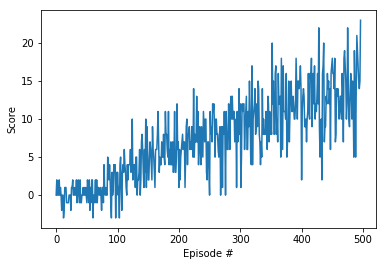

In [19]:
# Train the agent with Deep Q Learning
def dqn(n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, brain_name=brain_name, env=env, solve=False):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        brain_name (object): controller for environment
        env (objet): Unity ML Agent Banana collector environment
        solve (bool): Boolean to determine if learning should stop once environment is solved
        
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    env_info = env.reset(train_mode=True)[brain_name] # reset the environment
    state = env_info.vector_observations[0] # get the current state
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0] # get the current state
        score = 0
        while True:
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if solve:
            if np.mean(scores_window)>=13.0:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
                torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
                break
        else:
            if i_episode == n_episodes:
                print('\nMax episodes reached!\tFinal Average Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
                torch.save(agent.qnetwork_local.state_dict(), 'all-episodes-checkpoint.pth')
    return scores

scores = dqn(solve=True)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Training the Agent

There is a lot going on in the cell above, so I will summarise what is happening here.

1. We define the Q-learning function and arguments for number of episodes, epsilon start, epsilon end, epsilon decay rate, the brain name, the environment, and a boolean solve.
    * No. of episodes - tells the algorithm how many epsidoes we'd like to train for if the agent doesn't solve the environment before this number is reached
    * Epsilon start - the starting probability for the agent to choose a random action
    * Epsilon end - the lowest probability for the agent to choose a random action
    * Epsilon decay - the rate at which epsilon should decay from episode to episode down to epsilon end
    * The brain name - is the controller for the environment
    * The environment - is the Banana collector environment that we wish to train the agent in
    * Solve - whether the training should stop once the environment is solved, or continue until the max number of episodes is reached
    
2. Next we set variables for the score of each episode, a container for the score over the last 100 epsiodes, initial epsilon value, reset the environment and get the initial state info.
3. Then, for each episode we:
    * Reset the environment and the score
    ```
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        score = 0
    ```
    * Get the current state
    ```
        state = env_info.vector_observations[0] # get the current state
    ```
    * Until the episode ends we:
        * Get the agent to take an action which is chosen at random with probability epsilon, or by the greedy policy as learned by the online network if a sufficient number of episodes have passed
        ```
            action = agent.act(state, eps)
        ```
        * Pass the action to the environment and get the next state
        ```
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
        ```
        * Receive a reward for taking the previous action and arriving in the next state
        ```
            reward = env_info.rewards[0]
        ```
        * Check if the episode is done
        ```
            done = env_info.local_done[0]
        ```
        * Step the agent forward 1 step, the agent will then store the state, action, reward, next state, done tuple in memory for use in learning later (up to the maximum memory size as set in the agent parameters)
        ```
            agent.step(state, action, reward, next_state, done)
        ```
        * Set the current state to be the next state
        ```
            state = next_state
        ```
        * Update the score recieved for the most recent reward
        ```
            score += reward
        ```
        * Check if the episode has ended
        * Update the total scores for the episode and the rolling 100 episode window
        ```
            scores_window.append(score)       # save most recent score
            scores.append(score)
            
        ```
        * Finally we decay epsilon by the decay paramter - then we move to next episode if the environment has not been solved (and solved is set to True)
        * If the environment is solved, or the total number of episodes are reached print the results of the training

The agent will randomly sample a mini-batch of tuples from the S,A,R,S,A tuples stored in memory in order to learn from the actions it has taken in the various states it has observed, this happens every X steps where X is set to 4 in the agent parameters above.

The agent then uses Q-values generated from the target network and expected Q-values from the online network as input to the Bellman equation as follows:

<img src="images/fixed-q-target.png" width="75%">

I utilsed the smooth_l1_loss function to be used as the error term for the neural network to minimise on the target network. Smooth L1 Loss is described as follows:

Creates a criterion that uses a squared term if the absolute element-wise error falls below 1 and an L1 term otherwise. It is less sensitive to outliers than the MSELoss and in some cases prevents exploding gradients (e.g. see “Fast R-CNN” paper by Ross Girshick). Also known as the Huber loss:

![huber loss](images/Huber-loss.png)

where zi is given by:

![zi](images/zi.png)

x and y arbitrary shapes with a total of n elements each the sum operation still operates over all the elements, and divides by n.

We then do a 'soft copy' of the network weights from the online network to the target network in accordance with the following formula:

```
    θ_target = τ*θ_local + (1 - τ)*θ_target
```

Where Tau was defined in the Agent parameters above.

Over the course of many episodes the agent will use the memories of S,A,R,S,A sequences it has obsvered to form an optimal policy which becomes encoded in the weights of the online and target neural networks.

## Results

I experimented with several settings for both hyper-parameters of the agent and the structure of the neural networks in order to see how quickly the agent was able to solve the environment.

All of the following experiments were run with these arguments: **max number of episodes=2000, epsilon start=1.0, epsilon end=0.01, eps_decay=0.995.**

**Vanilla DQN**

Initial agent parameters:

```
BUFFER_SIZE = int(1e5)  # replay buffer size  
BATCH_SIZE = 64         # minibatch size  
GAMMA = 0.99            # discount factor  
TAU = 1e-3              # for soft update of target parameters  
LR = 5e-4               # learning rate  
UPDATE_EVERY = 4        # how often to update the network 
```

Neural Network:  

Fully connected layer 1 number of neurons = 64  
Fully connected layer 2 number of neurons = 64  

Algorithm:  
Vanilla Deep Q-Learning

Training Results (Baseline):

**Solved in 391 epsiodes**
![DQN](images/DQN.png)

**Double DQN**

Agent parameters:

```
BUFFER_SIZE = int(1e5)  # replay buffer size  
BATCH_SIZE = 64         # minibatch size  
GAMMA = 0.99            # discount factor  
TAU = 1e-3              # for soft update of target parameters  
LR = 5e-4               # learning rate  
UPDATE_EVERY = 4        # how often to update the network 
```

Neural Network:  

Fully connected layer 1 number of neurons = 64  
Fully connected layer 2 number of neurons = 64  

Algorithm:  
Double Deep Q-Learning (DDQN) - here the target network is used to generate the Q-values for the optimal actions provided by the online network. Those Q-values are then fed into the Bellman equation to update the Q-Targets as input for the loss minimisation step of the online network

<img src="images/double-DQN-equation.png" width="60%">

Training Results:

**Solved in 384 epsiodes**
<img src="images/DDQN.png">
![DDQN](images/DDQN-Chart.png)

**Dueling - Double DQN**

Agent parameters:

```
BUFFER_SIZE = int(1e5)  # replay buffer size  
BATCH_SIZE = 64         # minibatch size  
GAMMA = 0.99            # discount factor  
TAU = 1e-3              # for soft update of target parameters  
LR = 5e-4               # learning rate  
UPDATE_EVERY = 4        # how often to update the network 
```

Neural Network:  

Fully connected layer 1 number of neurons = 64  
Fully connected layer 2 number of neurons = 64  
Fully connected (advantage) layer 3 number of neurons = 4 (number of actions)  
Fully connected (value) layer 3 number of neurons = 1

Algorithm:  
Dueling Double Deep Q-Learning (DDQN) - Here we decompose the Q(s,a) value into V(s) of being in that state and A(s,a) the advantage of taking any action versus all the other actions in that state.

<img src="images/qsa-vs-asa.png" width="40%">

We can then split the final fully connected layer into two branches one for the advantage and one for the value as follows to get a Q value for each action and a single value for V(s):

<img src="images/dueling-ddqn-architecture.png" width="50%">

The results are then recombined according to the following equation:

<img src="images/dueling-ddqn-combination.png" width="60%">

The revised neural network architecture is as follows:

<img src="images/Dueling-DQN-Network.png">

Training Results:

**Solved in 401 epsiodes**
![DDQN](images/Dueling-DDQN.png)
![DDQN](images/Dueling-DDQN-Chart.png)

## Comment

All of the results of experiments thus far have yielded a similar time in episodes for the agent to solve the environment, with the main change being how stable the learning has become as we added the Q-learning improvements to the model and network.

**Dueling - Double DQN. Increased Batch Size**

Agent parameters:

```
BUFFER_SIZE = int(1e5)  # replay buffer size  
BATCH_SIZE = 128         # minibatch size  
GAMMA = 0.99            # discount factor  
TAU = 1e-3              # for soft update of target parameters  
LR = 5e-4               # learning rate  
UPDATE_EVERY = 4        # how often to update the network 
```

Neural Network:  

Fully connected layer 1 number of neurons = 64  
Fully connected layer 2 number of neurons = 64  
Fully connected (advantage) layer 3 number of neurons = 4 (number of actions)  
Fully connected (value) layer 3 number of neurons = 1

Algorithm:  
Dueling Double Deep Q-Learning (DDQN)

**Solved in 372 epsiodes**
<img src="images/Dueling-DDQN-Batch-128v2.png">
![DDQN](images/Dueling-DDQN-Chart-Batch-128.png)

**Dueling - Double DQN. Increased Batch Size + Increased Tau**

Agent parameters:

```
BUFFER_SIZE = int(1e5)  # replay buffer size  
BATCH_SIZE = 128         # minibatch size  
GAMMA = 0.99            # discount factor  
TAU = 1e-2              # for soft update of target parameters  
LR = 5e-4               # learning rate  
UPDATE_EVERY = 4        # how often to update the network 
```

Neural Network:  

Fully connected layer 1 number of neurons = 64  
Fully connected layer 2 number of neurons = 64  
Fully connected (advantage) layer 3 number of neurons = 4 (number of actions)  
Fully connected (value) layer 3 number of neurons = 1

Algorithm:  
Dueling Double Deep Q-Learning (DDQN)

**Solved in 414 epsiodes**
![DDQN](images/dueling-ddqn-increased-tau2.png)


## Comment

Increasing Tau - or the rate at which we incorporate learning from the online to the target network seems to decrease the speed at which the agent solves the environment vs. increased batch size alone.

I then tried experimenting with the number of neurons in the layers of the neural network with a suspicion that with less parameters to train the network might be able to learn faster. Here is a diagram of the revised neural network:

<img src="images/dueling-ddqn-32-hidden-architecture.png">

**Dueling - Double DQN. Increased Batch Size + Increased Tau + 32 hidden units**

Agent parameters:

```
BUFFER_SIZE = int(1e5)  # replay buffer size  
BATCH_SIZE = 128         # minibatch size  
GAMMA = 0.99            # discount factor  
TAU = 1e-2              # for soft update of target parameters  
LR = 5e-4               # learning rate  
UPDATE_EVERY = 4        # how often to update the network 
```

Neural Network:  

Fully connected layer 1 number of neurons = 32  
Fully connected layer 2 number of neurons = 32  
Fully connected (advantage) layer 3 number of neurons = 4 (number of actions)  
Fully connected (value) layer 3 number of neurons = 1

Algorithm:  
Dueling Double Deep Q-Learning (DDQN)

**Solved in 410 epsiodes**
<img src="images/dueling-ddqn-increased-tau.png">

## Comment

Changing the number of hidden units seemed to have little impact on the speed of solving the environment.

Finally I looked at increasing the rate of epsilon decay, under the hypothesis that given the limited number of states in the environment the agent might not need to take exploratory actions for many steps in order to build a near optimal policy.

**Dueling - Double DQN. Increased Batch Size + Increased Tau + 32 hidden units + Epsilon Decay = 0.95**

Agent parameters:

```
BUFFER_SIZE = int(1e5)  # replay buffer size  
BATCH_SIZE = 128         # minibatch size  
GAMMA = 0.99            # discount factor  
TAU = 1e-2              # for soft update of target parameters  
LR = 5e-4               # learning rate  
UPDATE_EVERY = 4        # how often to update the network 
```

Neural Network:  

Fully connected layer 1 number of neurons = 32  
Fully connected layer 2 number of neurons = 32  
Fully connected (advantage) layer 3 number of neurons = 4 (number of actions)  
Fully connected (value) layer 3 number of neurons = 1

Algorithm:  
Dueling Double Deep Q-Learning (DDQN)

**Solved in 286 epsiodes**
<img src="images/dueling-ddqn-eps_decay0.95.png" width="55%">
<img src="images/dueling-ddqn-eps_decay0.95-chart.png" width="40%">

## Comment

This is the biggest improvement in number of episodes to solve the environment so far! I then continued with several experiments, each increasing the amount of epsilon decay, to a final epsilon decay of 0.7 and my optimal agent.

**Dueling - Double DQN. Increased Batch Size + Increased Tau + 32 hidden units + Epsilon Decay = 0.7**

Agent parameters:

```
BUFFER_SIZE = int(1e5)  # replay buffer size  
BATCH_SIZE = 128         # minibatch size  
GAMMA = 0.99            # discount factor  
TAU = 1e-2              # for soft update of target parameters  
LR = 5e-4               # learning rate  
UPDATE_EVERY = 4        # how often to update the network 
```

Neural Network:  

Fully connected layer 1 number of neurons = 32  
Fully connected layer 2 number of neurons = 32  
Fully connected (advantage) layer 3 number of neurons = 4 (number of actions)  
Fully connected (value) layer 3 number of neurons = 1

Algorithm:  
Dueling Double Deep Q-Learning (DDQN)

**Solved in 126 epsiodes**
<img src="images/dueling-ddqn-eps_decay0.7-plus-chart.png" width="55%">

## Conclusion

It seems as though this agent is able to score 13 points required to solve the environment in approximately 50 episodes, so any exploration beyond this point only acts to increase the time taken to solve the environment. This is likely due to the environment's relative simplicity and the limited number of actions the agent can take in the environment.

As a result, decaying epsilon quickly to the minimum value allows the agent to act greedily as soon as possible and reach the 13 point average score over 100 episodes in the shortest period.

It may be possible to further improve the performance of the agent by implementing Q-learning improvements such as: prioritised experience replay (boosting the sampling of experiences which are likely to lead to the greatest improvements in the error term of the network and thus the estimation of Q-values), or Dyna-Q which blends Q-planning and Q-learning so that the agent is able to build a model of the environment as it learns, thus drastically reducing the number ineractions the agent needs to have with its environment before it learns a near optimal policy.

## Watch the trained agent

Click on the screenshot below to watch my best performing agent act in the Unity Banana Collector environment.

<a href="http://www.youtube.com/watch?feature=player_embedded&v=GFSBQ08WmTQ
" target="_blank"><img src="http://img.youtube.com/vi/GFSBQ08WmTQ/0.jpg" 
alt="Youtube Video of Agent in Environment" width="400" height="300" border="10" /></a>

If you have set up the environment per the instructions in the README file you can watch the agent interact with the environment by running the code below. 

Don't forget to close the environment when you're finished!

In [ ]:
# Load an agent and watch it act

# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('dueling-ddqn-checkpoint-solved-126-nn-change-0.7eps_decay.pth'))

state = env_info.vector_observations[0] # get the current state

for i in range(3):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    score = 0
    for j in range(200):
        action = agent.act(state)
        env_info = env.step(action)[brain_name]
        state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        score += reward
        if done:
            break 
        

In [7]:
# Close the environment when done
env.close()